<h1>Description</h1>

<p>The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level.</p>

<b>Features:</b>
<ul>
    <li><span style='color:#26a06c'>Gender</span>: refers to the biological sex of the individual, which can have an impact on their susceptibility to diabetes</li>
    <li><span style='color:#26a06c'>Age</span>: is an important factor as diabetes is more commonly diagnosed in older adults.Age ranges from 0-80 in our dataset.</li>
    <li><span style='color:#26a06c'>Hypertension</span>: is a medical condition in which the blood pressure in the arteries is persistently elevated. It has values a 0 or 1 where 0 indicates they don’t have hypertension and for 1 it means they have hypertension.</li>
    <li><span style='color:#26a06c'>Heart disease</span>: is another medical condition that is associated with an increased risk of developing diabetes. It has values a 0 or 1 where 0 indicates they don’t have heart disease and for 1 it means they have heart disease.</li>
    <li><span style='color:#26a06c'>Smoking history</span>: is also considered a risk factor for diabetes and can exacerbate the complications associated with diabetes.In our dataset we have 5 categories i.e not current,former,No Info,current,never and ever.</li>
    <li><span style='color:#26a06c'>BMI (Body Mass Index)</span>: is a measure of body fat based on weight and height. Higher BMI values are linked to a higher risk of diabetes. The range of BMI in the dataset is from 10.16 to 71.55. BMI less than 18.5 is underweight, 18.5-24.9 is normal, 25-29.9 is overweight, and 30 or more is obese.</li>
    <li><span style='color:#26a06c'>HbA1c (Hemoglobin A1c) level</span>: is a measure of a person's average blood sugar level over the past 2-3 months. Higher levels indicate a greater risk of developing diabetes. Mostly more than 6.5% of HbA1c Level indicates diabetes.</li>
    <li><span style='color:#26a06c'>Blood glucose level</span>: refers to the amount of glucose in the bloodstream at a given time. High blood glucose levels are a key indicator of diabetes.</li>
    <li><span style='color:#3498db'>Diabetes</span>: is the target variable being predicted, with values of 1 indicating the presence of diabetes and 0 indicating the absence of diabetes.</li>
</ul>

In [116]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from skopt.space import Integer, Real
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt import BayesSearchCV

import shap
import eli5
from eli5.sklearn import PermutationImportance

sns.set_style("darkgrid")

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")
start_time = time.time()

Skipping, found downloaded files in "../datasets/diabetes-prediction-dataset" (use force=True to force download)


In [2]:
df = pd.read_csv(os.path.join(DATA_PATH, os.listdir(DATA_PATH)[0]))

<h2>EDA</h2>

In [ ]:
# Drop duplicated rows
print(f"There are {df.duplicated().sum()} duplicated rows")
print(f"Shape before duplicated removal: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after duplicated removal: {df.shape}")

There are 3854 duplicated rows
Shape before duplicated removal: (100000, 9)
Shape after duplicated removal: (96146, 9)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,41.89,0.07,0.04,27.32,5.53,138.06,0.09
std,22.52,0.26,0.19,6.64,1.07,40.71,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.63,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,60.00,0.00,0.00,29.58,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [6]:
df.describe(include=["object"]).T

,count,unique,top,freq
gender,100000,3,Female,58552
smoking_history,100000,6,No Info,35816


In [8]:
# Show the unique values of each column
for c in df:
    print(f"{c}: {df[c].nunique()} unique values")

gender: 3 unique values
age: 102 unique values
hypertension: 2 unique values
heart_disease: 2 unique values
smoking_history: 6 unique values
bmi: 4247 unique values
HbA1c_level: 18 unique values
blood_glucose_level: 18 unique values
diabetes: 2 unique values


In [9]:
df.gender.value_counts(normalize=True)

gender
Female    0.584122
Male      0.415691
Other     0.000187
Name: proportion, dtype: float64

Dropping other since is a really small % 

In [10]:
df = df.loc[df.gender != "Other", :]

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%">Univariate Analysis</span>

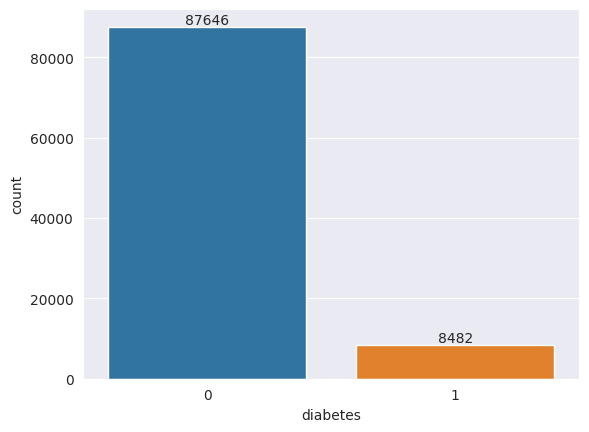

In [11]:
# Count plot for the target variable
ax = sns.countplot(df, x="diabetes")
for container in ax.containers:
    ax.bar_label(container)

In [12]:
df.diabetes.value_counts(normalize=True)

diabetes
0    0.911763
1    0.088237
Name: proportion, dtype: float64

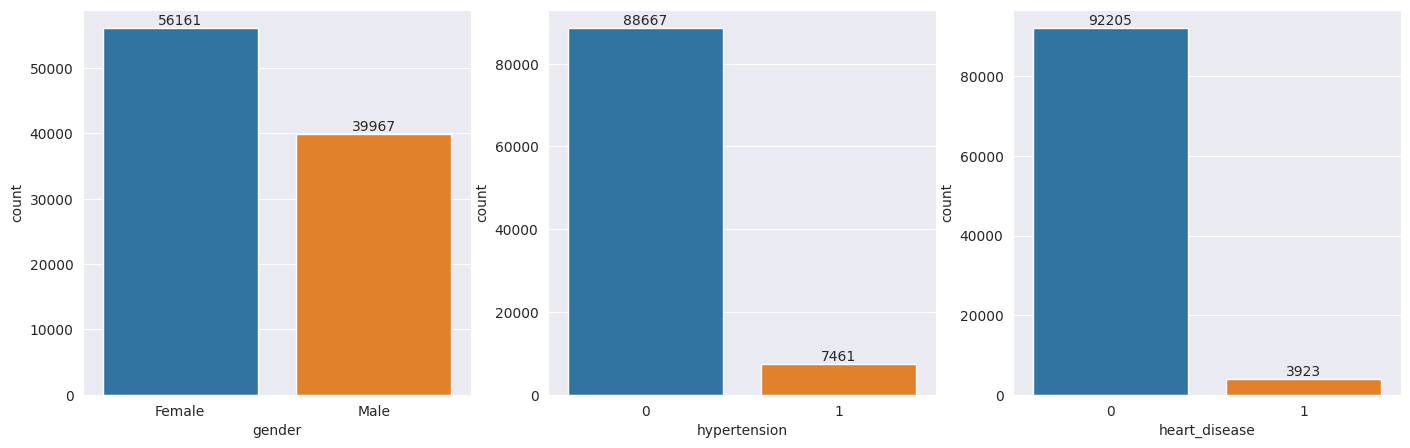

In [13]:
# Gender, hypertension and heart_disease countplots
plt.figure(figsize=(17,5))
ax1 = plt.subplot(1,3,1)
sns.countplot(df, x="gender", ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container)
ax2 = plt.subplot(1,3,2)
sns.countplot(df, x="hypertension", ax=ax2)
for container in ax2.containers:
    ax2.bar_label(container)
ax3 = plt.subplot(1,3,3)
sns.countplot(df, x="heart_disease", ax=ax3)
for container in ax3.containers:
    ax3.bar_label(container)

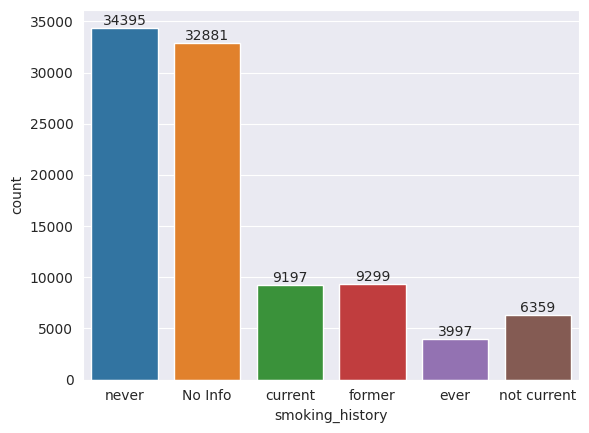

In [14]:
ax = sns.countplot(df, x="smoking_history")
for container in ax.containers:
    ax.bar_label(container)

Text(0.5, 1.0, 'Age distribution')

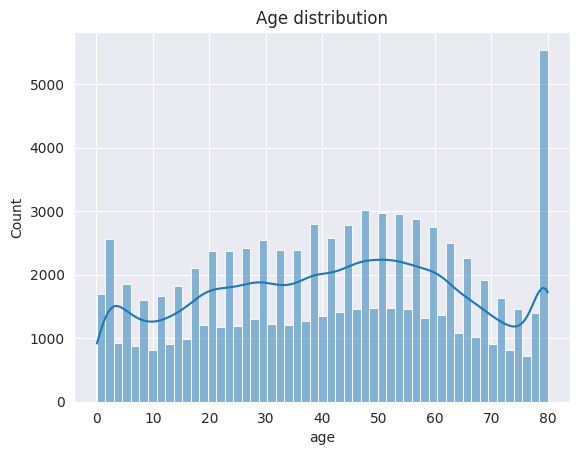

In [15]:
sns.histplot(df, x="age", kde=True)
plt.title("Age distribution")

Text(0.5, 1.0, 'BMI distribution')

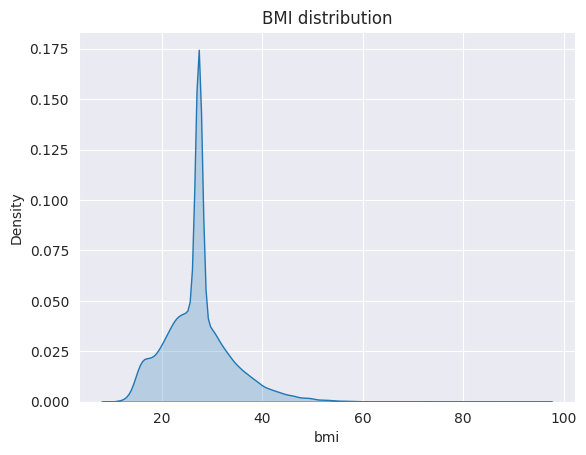

In [16]:
sns.kdeplot(df["bmi"], fill=True)
plt.title("BMI distribution")

<b><u>Plot observations</u></b>:
<ul>
    <li>We have an imbalance classification problem, 91% negative class and 8.8% positive class for <span style='color:#3498db'>diabetes</span>.</li>
    <li><span style='color:#26a06c'>hypertension</span> and <span style='color:#26a06c'>heart_disease</span> have skewed distributions</li>
    <li><span style='color:#26a06c'>BMI</span> distributions looks heavily centered around value 29</li>

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%">Bivariate Analysis</span>

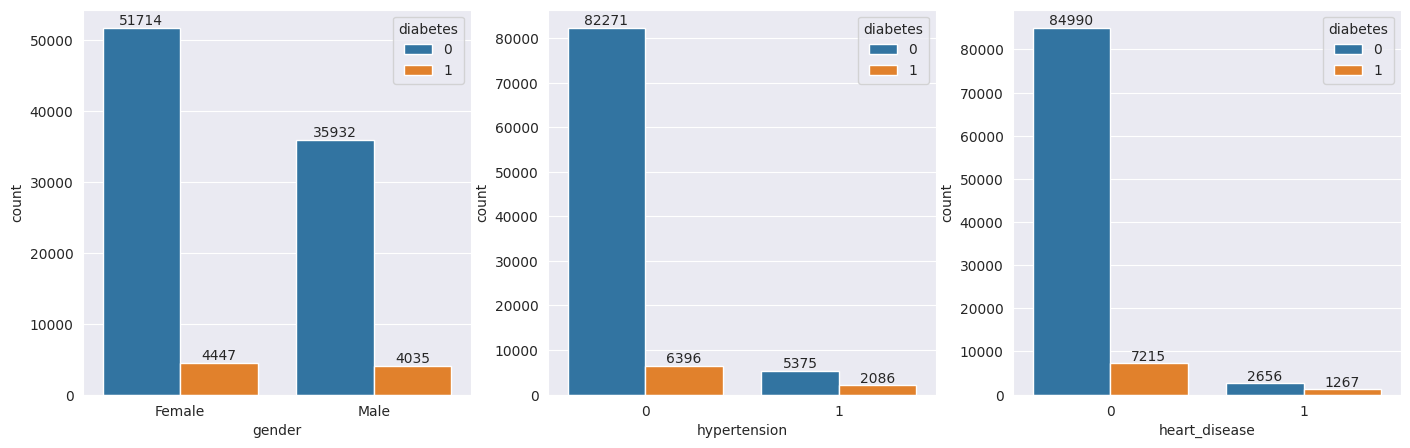

In [17]:
# Gender, hypertension and heart_disease countplots
plt.figure(figsize=(17,5))
ax1 = plt.subplot(1,3,1)
sns.countplot(df, x="gender", hue="diabetes", ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container)
ax2 = plt.subplot(1,3,2)
sns.countplot(df, x="hypertension", hue="diabetes", ax=ax2)
for container in ax2.containers:
    ax2.bar_label(container)
ax3 = plt.subplot(1,3,3)
sns.countplot(df, x="heart_disease", hue="diabetes", ax=ax3)
for container in ax3.containers:
    ax3.bar_label(container)

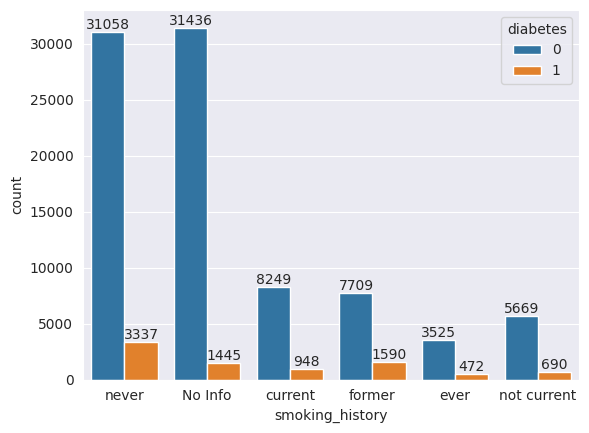

In [18]:
ax = sns.countplot(df, x="smoking_history", hue="diabetes")
for container in ax.containers:
    ax.bar_label(container)

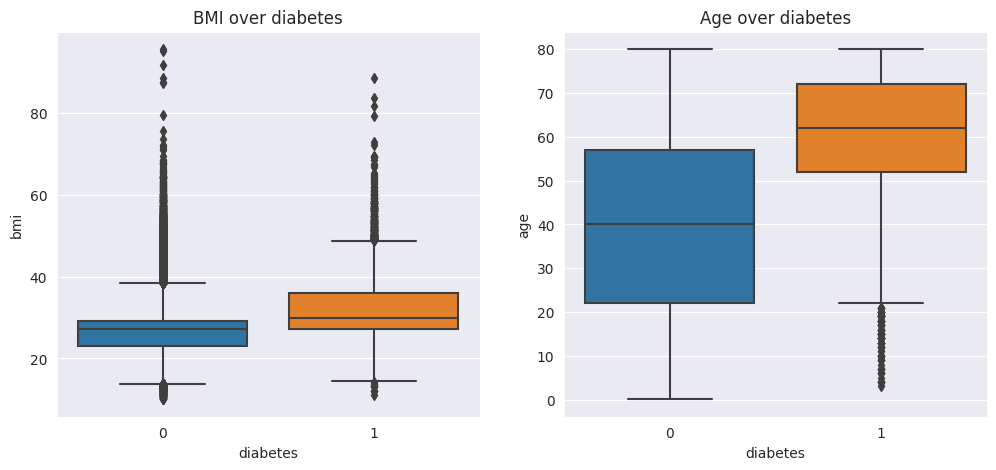

In [19]:
# BMI and Age box plots over diabetes
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, x="diabetes", y="bmi", ax=ax1)
ax1.set_title("BMI over diabetes")
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, x="diabetes", y="age", ax=ax2)
ax2.set_title("Age over diabetes")
plt.show()

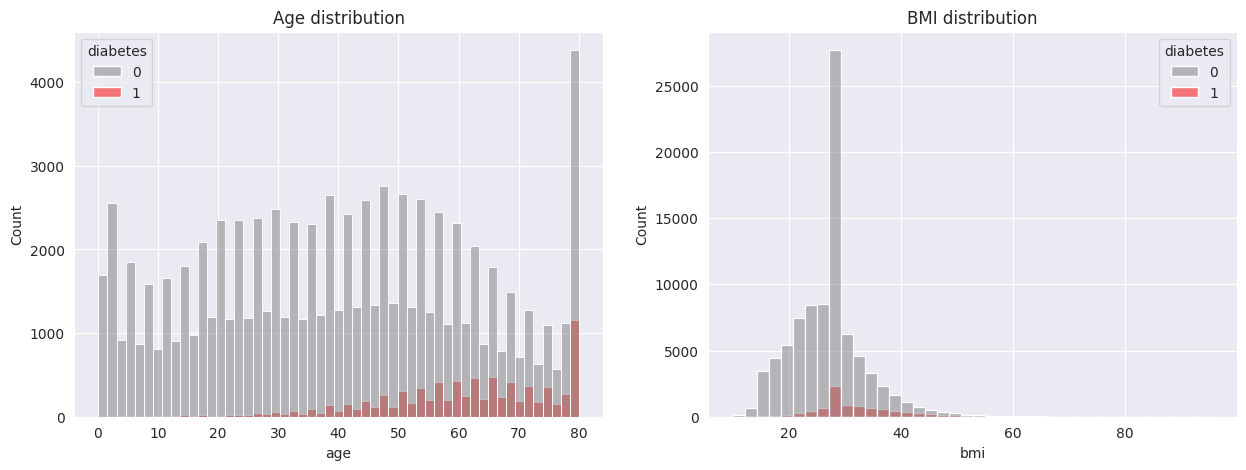

In [20]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
sns.histplot(df, x="age", hue="diabetes", palette=["gray", "red"], ax=ax1)
ax1.set_title("Age distribution")
ax2 = plt.subplot(1,2,2)
sns.histplot(df, x="bmi", hue="diabetes", palette=["gray", "red"], bins=40, ax=ax2)
ax2.set_title("BMI distribution")
plt.show()

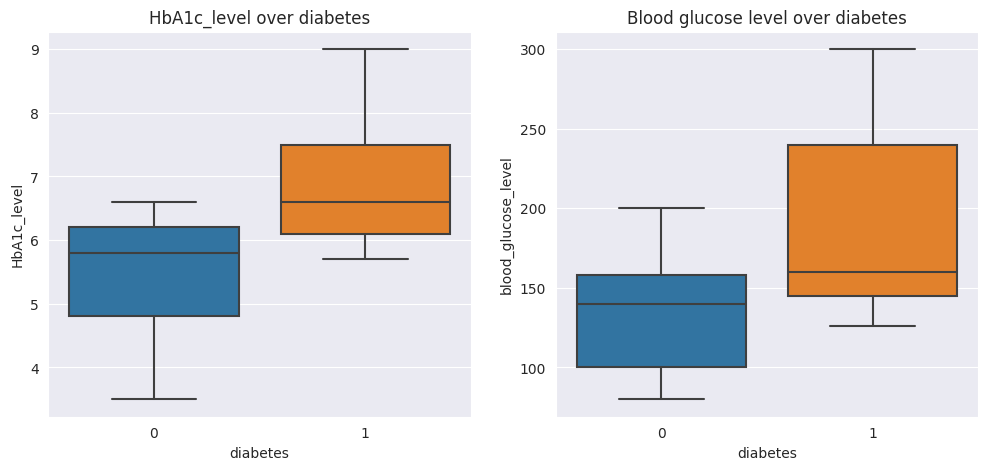

In [21]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, x="diabetes", y="HbA1c_level", ax=ax1)
ax1.set_title("HbA1c_level over diabetes")
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, x="diabetes", y="blood_glucose_level", ax=ax2)
ax2.set_title("Blood glucose level over diabetes")
plt.show()

In [22]:
# ANOVA and t-test
hyper = df[df["hypertension"] == 1]["diabetes"].tolist()
nohyper = df[df["hypertension"] == 0]["diabetes"].tolist()

print("hypertension")
f_value, p_value = stats.f_oneway(hyper, nohyper)
print(f"ANOVA  -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

f_value, p_value = stats.ttest_ind(hyper, nohyper, equal_var=False)
print(f"t-test -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

hypertension
ANOVA  -> f_value: 3827.933
	  p_value: 0.00000
t-test -> f_value: 39.378
	  p_value: 0.00000


In [23]:
# ANOVA and t-test
hyper = df[df["diabetes"] == 1]["HbA1c_level"].tolist()
nohyper = df[df["diabetes"] == 0]["HbA1c_level"].tolist()

print("HbA1c_level")
f_value, p_value = stats.f_oneway(hyper, nohyper)
print(f"ANOVA  -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

f_value, p_value = stats.ttest_ind(hyper, nohyper, equal_var=False)
print(f"t-test -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

HbA1c_level
ANOVA  -> f_value: 19022.304
	  p_value: 0.00000
t-test -> f_value: 126.685
	  p_value: 0.00000


In [24]:
# ANOVA and t-test
hyper = df[df["diabetes"] == 1]["blood_glucose_level"].tolist()
nohyper = df[df["diabetes"] == 0]["blood_glucose_level"].tolist()

print("blood_glucose_level")
f_value, p_value = stats.f_oneway(hyper, nohyper)
print(f"ANOVA  -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

f_value, p_value = stats.ttest_ind(hyper, nohyper, equal_var=False)
print(f"t-test -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

blood_glucose_level
ANOVA  -> f_value: 21113.250
	  p_value: 0.00000
t-test -> f_value: 94.600
	  p_value: 0.00000


In [25]:
# ANOVA and t-test
hyper = df[df["heart_disease"] == 1]["diabetes"].tolist()
nohyper = df[df["heart_disease"] == 0]["diabetes"].tolist()

print("heart_disease")
f_value, p_value = stats.f_oneway(hyper, nohyper)
print(f"ANOVA  -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

f_value, p_value = stats.ttest_ind(hyper, nohyper, equal_var=False)
print(f"t-test -> f_value: {f_value:.3f}\n\t  p_value: {p_value:.5f}")

heart_disease
ANOVA  -> f_value: 2885.071
	  p_value: 0.00000
t-test -> f_value: 32.547
	  p_value: 0.00000


<b><u>Observations</u></b>:<br>
<p>From the plots and the tests we see that <span style='color:#26a06c'>hypertension</span>, <span style='color:#26a06c'>heart_disease</span>, <span style='color:#26a06c'>blood_glucose_level</span> and <span style='color:#26a06c'>HbA1c_level</span> distributions over <span style='color:#3498db'>diabetes</span> have statistical significant difference<p>

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:130%;">Multivariate Analysis</span>

<Axes: xlabel='diabetes', ylabel='age'>

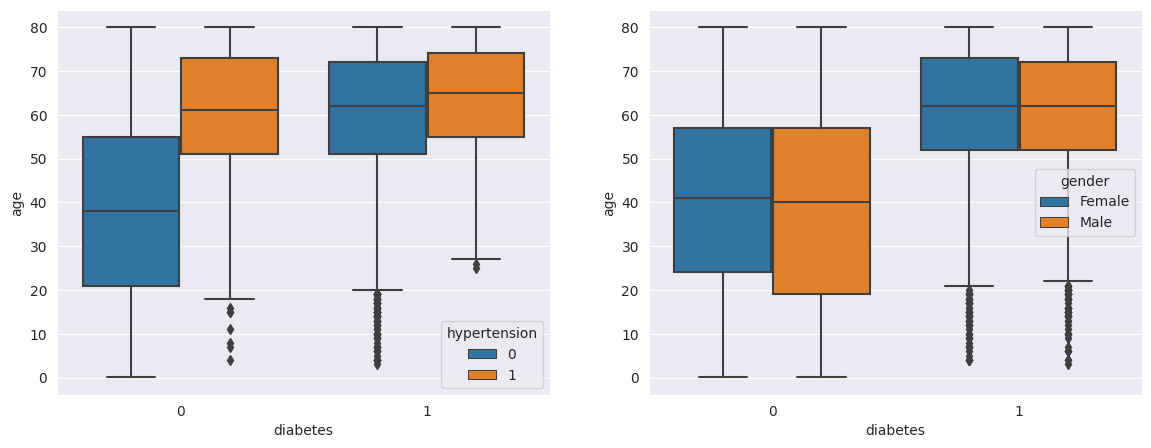

In [26]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, x="diabetes", y="age", hue="hypertension", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, x="diabetes", y="age", hue="gender", ax=ax2)

<Axes: xlabel='diabetes', ylabel='blood_glucose_level'>

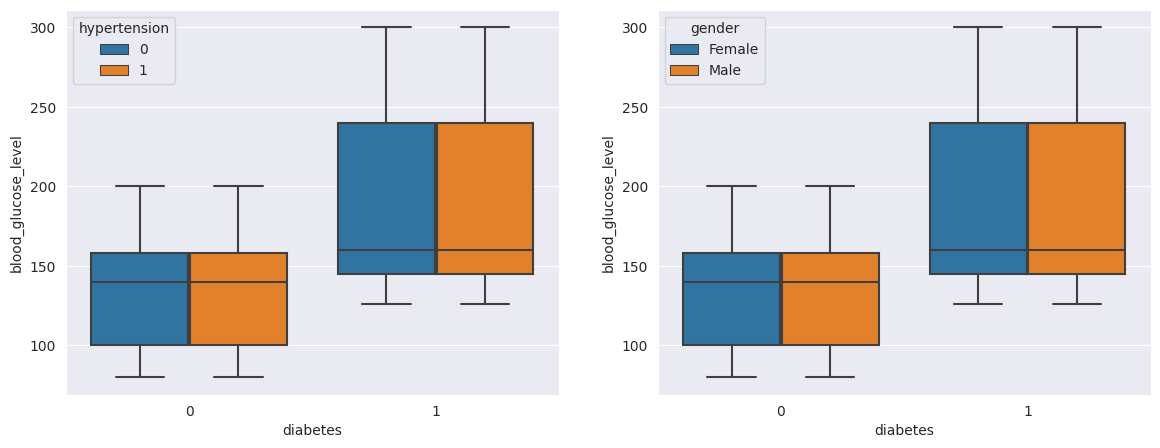

In [27]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, x="diabetes", y="blood_glucose_level", hue="hypertension", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, x="diabetes", y="blood_glucose_level", hue="gender", ax=ax2)

<Axes: xlabel='diabetes', ylabel='HbA1c_level'>

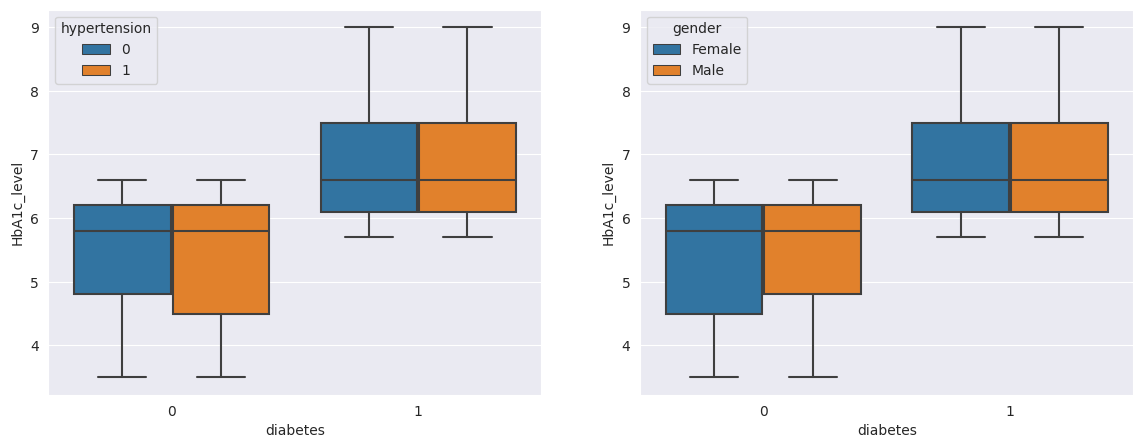

In [28]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, x="diabetes", y="HbA1c_level", hue="hypertension", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, x="diabetes", y="HbA1c_level", hue="gender", ax=ax2)

<Axes: xlabel='age', ylabel='HbA1c_level'>

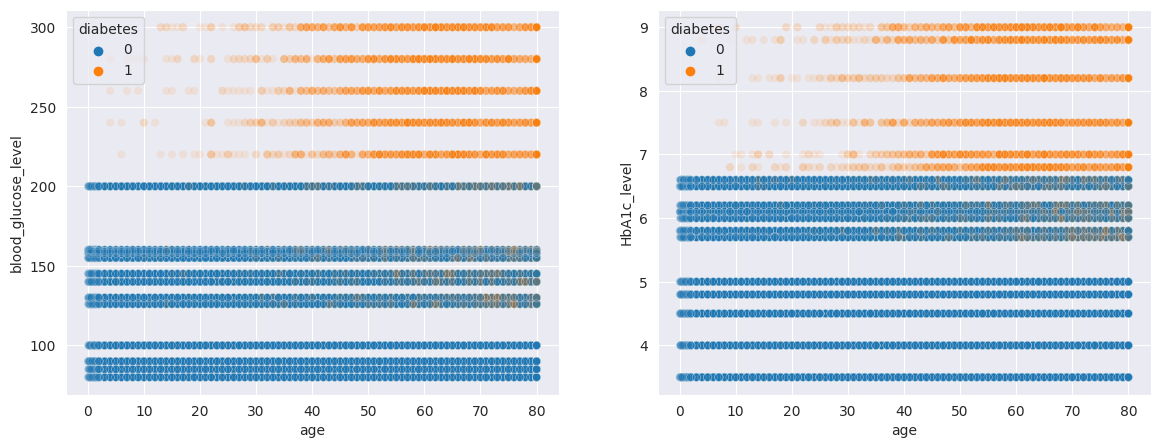

In [29]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(df, x="age", y="blood_glucose_level", hue="diabetes", alpha=0.1, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(df, x="age", y="HbA1c_level", hue="diabetes", alpha=0.1, ax=ax2)

<b><u>Observations</u></b>:
<ul>
    <li><span style='color:#26a06c'>Hypertension</span> is seen mostly on higher ages.</li>
    <li>Both genders have similar distributions on <span style='color:#26a06c'>age</span>, <span style='color:#26a06c'>blood_glucose_level</span>, <span style='color:#26a06c'>HbA1c_level</span> over <span style='color:#3498db'>diabetes</span>.</li>
    <li>People have similar <span style='color:#26a06c'>HbA1c_level</span> and <span style='color:#26a06c'>blood_glucose_level</span> over <span style='color:#26a06c'>hypertension</span>.</li>
    <li>People with higher <span style='color:#26a06c'>blood_glucose_level</span> and <span style='color:#26a06c'>HbA1c_level</span> and <span style='color:#3498db'>diabetes</span> tend to be older.</li>
</ul>

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%;">Correlation</span>

In [30]:
# Group up smoking history 
def map_smoker(x):
    if x in ["never", "No Info"]:
        return "non_smoker"
    elif x in ["former", "not current"]:
        return "past_smoker"
    elif x in ["ever", "current"]:
        return "smoker"
    
df = df.assign(smoking_history = lambda x: x["smoking_history"].map(map_smoker))

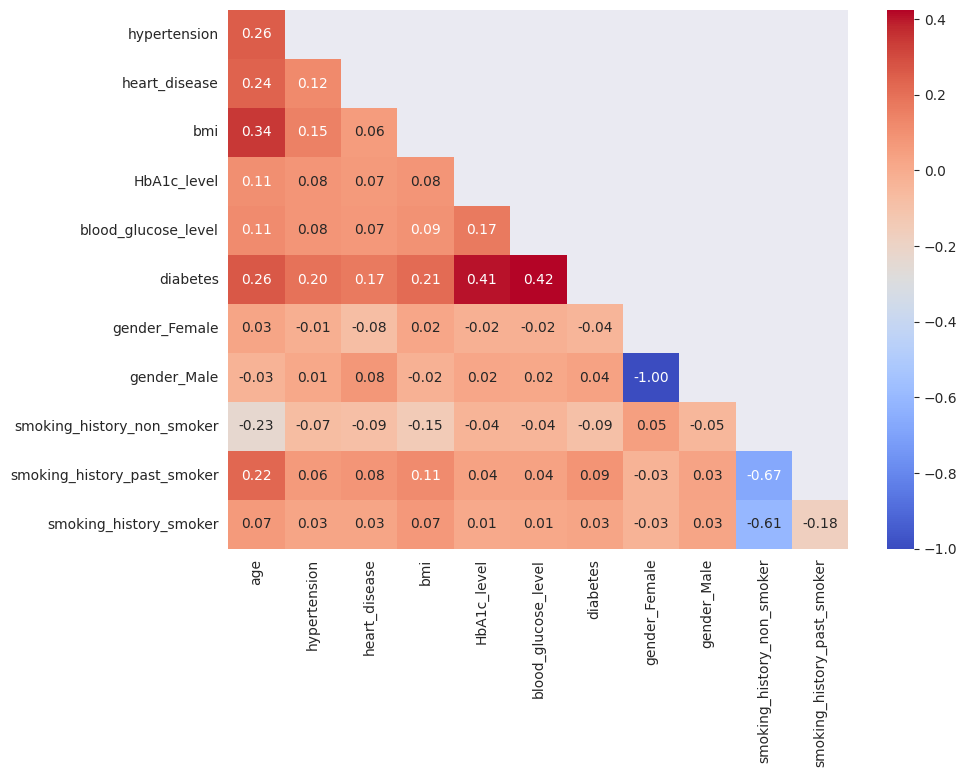

In [31]:
# Heatmap for correlation matrix
df_oh = pd.get_dummies(df)
corr_mat = df_oh.corr()
mask = np.triu(np.ones_like(corr_mat).astype(bool))[1:, :-1]
plt.figure(figsize=(10,7))
sns.heatmap(corr_mat.iloc[1:, :-1], mask = mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.grid(False)

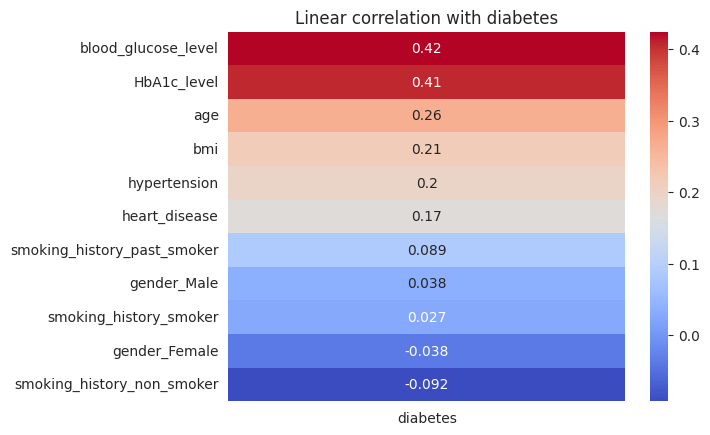

In [32]:
# Heatmap over diabetes
sns.heatmap(corr_mat["diabetes"].sort_values(ascending=False)[1:].to_frame(), annot=True, cmap="coolwarm")
plt.title("Linear correlation with diabetes")
plt.show()

<Axes: >

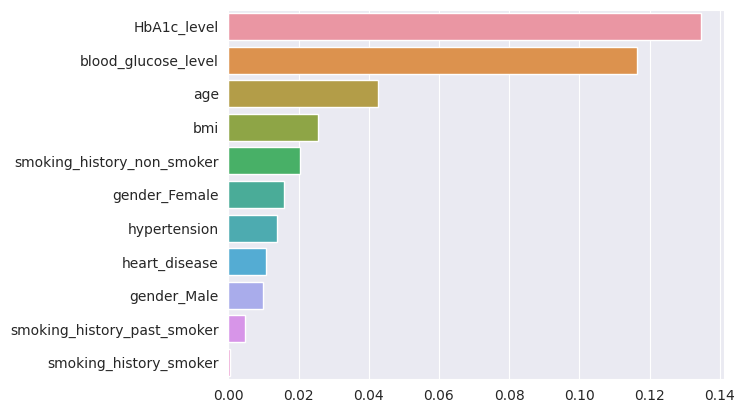

In [33]:
# Mutual information
mi_scores = mutual_info_classif(df_oh.drop(columns=["diabetes"]), df_oh["diabetes"])
mi_scores = pd.Series(mi_scores, index=df_oh.drop(columns=["diabetes"]).columns).sort_values(ascending=False)

sns.barplot(x=mi_scores.values, y=mi_scores.index)

<b><u>Observations</u></b>:<br>
<p><span style='color:#26a06c'>HbA1c_level</span> and <span style='color:#26a06c'>blood_glucose_level</span> seem to have the biggest correlation with <span style='color:#3498db'>diabetes</span>.</p>

<h2>Modeling</h2>
<p>Since the target is imbalanced (approximately 90% - 10%), in order to avoid target bias by the model, <b><span style='color:#16C2D5'>Synthetic Minority Oversampling Technique</span></b> (SMOTE) in conjunction with undersampling on the majority class will be used to address that issue</p> 

In [34]:
# Split the dataset to train and test datasets
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["diabetes"]) 
X_train, y_train = df_train.drop(columns=["diabetes"]), df_train["diabetes"].copy()
X_test, y_test = df_test.drop(columns=["diabetes"]), df_test["diabetes"].copy()

In [46]:
# Pipelines for the optimization
transformer = ColumnTransformer([
    ("num", StandardScaler(), X_train.select_dtypes(exclude=["object"]).columns.tolist()),
    ("cat", OneHotEncoder(), ["smoking_history", "gender"]),
])

preprocess = Pipeline([
    ("transformer", transformer),
    ("over", SMOTE(sampling_strategy=0.4, k_neighbors=8, random_state=47)),
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=47)),
])

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%;">Model Optimization</span>

In [47]:
# Search space for the bayesian optimization 
search_space = {
    'n_estimators': Integer(900, 2000),
    'max_depth': Integer(1, 12),
    'l2_leaf_reg': Integer(1, 100, "log-uniform"),
    'random_strength': Real(1e-9, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'learning_rate': Real(0.001, 1, "log-uniform")
    }

# preprocess the data
X_train_proc, y_train_proc = preprocess.fit_resample(X_train, y_train)

scoring = make_scorer(f1_score, 
                      greater_is_better=False)

model = CatBoostClassifier(verbose=False, random_state=47)

# Define the optimization
opt = BayesSearchCV(estimator=model, 
              search_spaces=search_space, 
              cv=5, 
              n_iter=60, 
              n_points=4, 
              scoring=scoring, 
              optimizer_kwargs={'base_estimator': 'GP'},
              n_jobs=-1, 
              random_state=47)

# Optimization callbacks
opt_gain_ctrl = DeltaYStopper(delta=0.0001) # We stop if the gain of the optimization becomes too small
time_limit_ctrl = DeadlineStopper(total_time=60*20) # We impose a time limit (20 minutes)
# perform optimization
t1 = time.time()
opt.fit(X_train_proc, y_train_proc, callback=[opt_gain_ctrl, time_limit_ctrl])
opt_time = time.time() - t1

minutes = opt_time//60
seconds = opt_time - minutes*60
# summarizing findings:
print(f"Total time: {minutes} minutes and {seconds:.2f}s")
print(f"Best f1 score: {-opt.best_score_:.4f}\nBest params:")
for k in search_space:
    print(f"    {k} -> {opt.best_params_[k]}")

Total time: 22.0 minutes and 46.06s
Best f1 score: 0.9240
Best params:
    n_estimators -> 1951
    max_depth -> 9
    l2_leaf_reg -> 3
    random_strength -> 1.3000382902671279e-08
    bagging_temperature -> 0.3201356468419944
    learning_rate -> 0.0010092095384545237


In [101]:
# Define the full pipeline with the best model parameters from the optimization
model = CatBoostClassifier(random_state=47, verbose=False)
model.set_params(**opt.best_params_)

full_pipe = Pipeline([
    ("transformer", transformer),
    ("over", SMOTE(sampling_strategy=0.4, k_neighbors=8, random_state=47)),
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=47)),
    ("model", model),
])

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%;">Cross Validation</span>

In [102]:
# Cross validation for f1 scores
scores = cross_val_score(full_pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="f1", n_jobs=-1)
print("Average CV f1 score:", np.mean(scores))
print(f"95% f1 score confidence interval: {stats.t.interval(0.95, len(scores) - 1, loc=scores.mean(), scale=stats.sem(scores))}")

Average CV f1 score: 0.7928676031889406
95% f1 score confidence interval: (0.7892550337773662, 0.796480172600515)


In [103]:
# Cross validation for predictions
cv_preds = cross_val_predict(full_pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
print(f"f1 score on unseen data: {f1_score(y_train, cv_preds)}")

f1 score on unseen data: 0.7928605730750761


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     70116
           1       0.87      0.73      0.79      6786

    accuracy                           0.97     76902
   macro avg       0.92      0.86      0.89     76902
weighted avg       0.96      0.97      0.97     76902



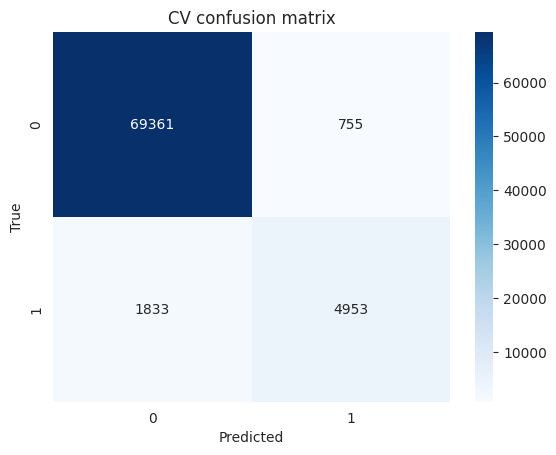

In [104]:
print(classification_report(y_train, cv_preds))
cm = pd.DataFrame(confusion_matrix(y_train, cv_preds), columns=["0", "1"], index=["0", "1"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("CV confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<b>Results</b>
<ul>
    <li>Even if the model was able to achieve 97% accuracy (classified 97% of the dataset correctly) the results were biased because of the majority class. Only 73% of the minority class was predicted correclty which shows the struggle of the model on the minority class.</li>
    <li>The model when predicting <span style='color:#3498db'>diabetes</span> it has 87% to be correct, but it detects only 73% of the <span style='color:#3498db'>diabetes</span> cases.</li>
    <li>The model when predicting not <span style='color:#3498db'>diabetes</span> it has 97% to be correct and it detects 99% of the not <span style='color:#3498db'>diabetes</span> cases.</li>
    <li>It is clear that the class imbalance in the dataset affected the perfmornace of the model.</li>
</ul> 

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%;">Model Explainability - Test set evaluation</span>

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17530
           1       0.88      0.74      0.80      1696

    accuracy                           0.97     19226
   macro avg       0.93      0.86      0.89     19226
weighted avg       0.97      0.97      0.97     19226



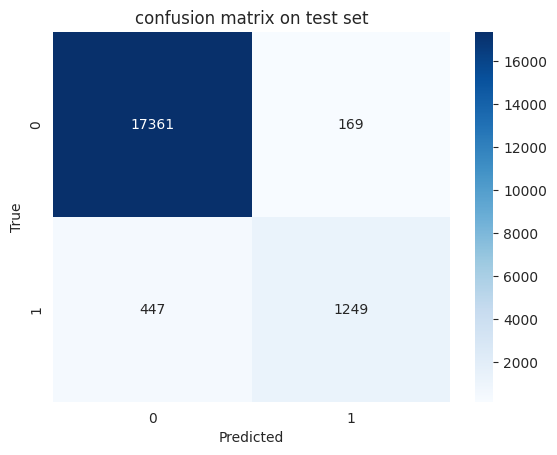

In [105]:
full_pipe.fit(X_train, y_train)
preds = full_pipe.predict(X_test)

print(classification_report(y_test, preds))
cm = pd.DataFrame(confusion_matrix(y_test, preds), columns=["0", "1"], index=["0", "1"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix on test set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [106]:
# Permutation Importance
X_test_oh = pd.get_dummies(X_test)
X_train_oh = pd.get_dummies(X_train)

perm_pipe = Pipeline([
    ("over", SMOTE(sampling_strategy=0.4, k_neighbors=8, random_state=47)),
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=47))
])

X_train_proc, y_train_proc = perm_pipe.fit_resample(X_train_oh, y_train)
model = CatBoostClassifier(random_state=47, verbose=False)
model.set_params(**opt.best_params_)
model.fit(X_train_proc, y_train_proc)

perm = PermutationImportance(model, random_state=47).fit(X_test_oh, y_test)
eli5.show_weights(perm, feature_names=X_test_oh.columns.tolist())

Weight,Feature
0.0840 ± 0.0016,gender_Male
0.0797 ± 0.0020,gender_Female
0.0599 ± 0.0007,blood_glucose_level
0.0478 ± 0.0014,HbA1c_level
0.0267 ± 0.0014,smoking_history_non_smoker
0.0125 ± 0.0012,smoking_history_past_smoker
0.0123 ± 0.0009,smoking_history_smoker
0.0014 ± 0.0004,bmi
0.0010 ± 0.0004,age
0.0001 ± 0.0000,heart_disease


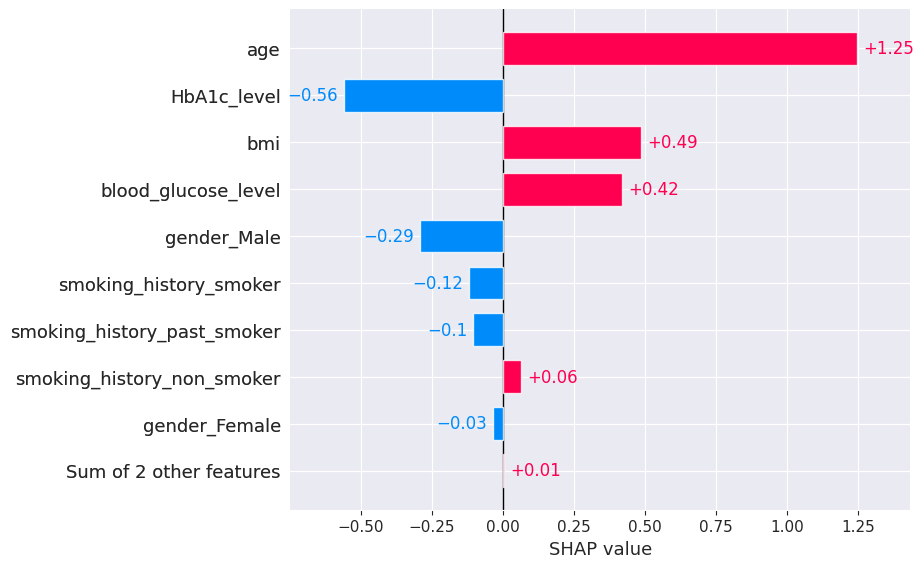

In [111]:
# explain the model's predictions using SHAP
for c in X_train_proc.select_dtypes("bool"):
    X_train_proc[c] = X_train_proc[c].astype("int64")
explainer = shap.Explainer(model)
shap_values = explainer(X_train_proc)

# visualize shap values for positive class
shap.plots.bar(shap_values[1])

In [120]:
shap.initjs()
shap.plots.force(shap_values[1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


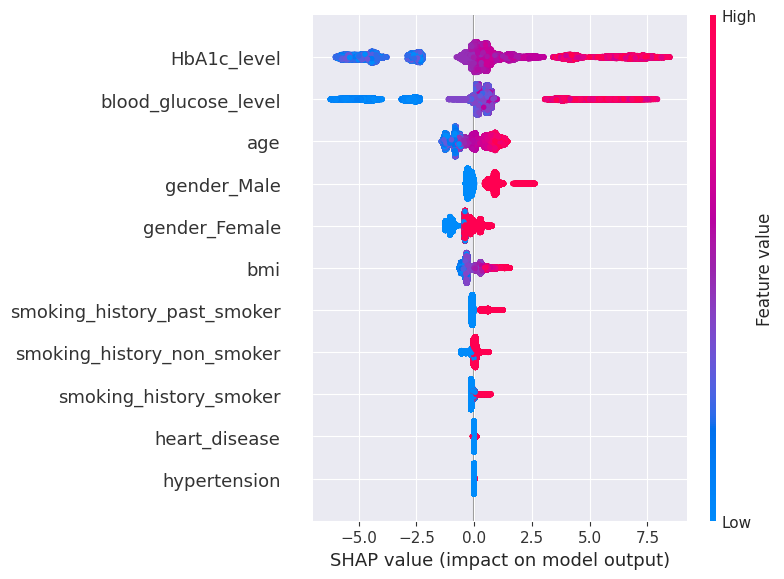

In [115]:
shap.summary_plot(shap_values)

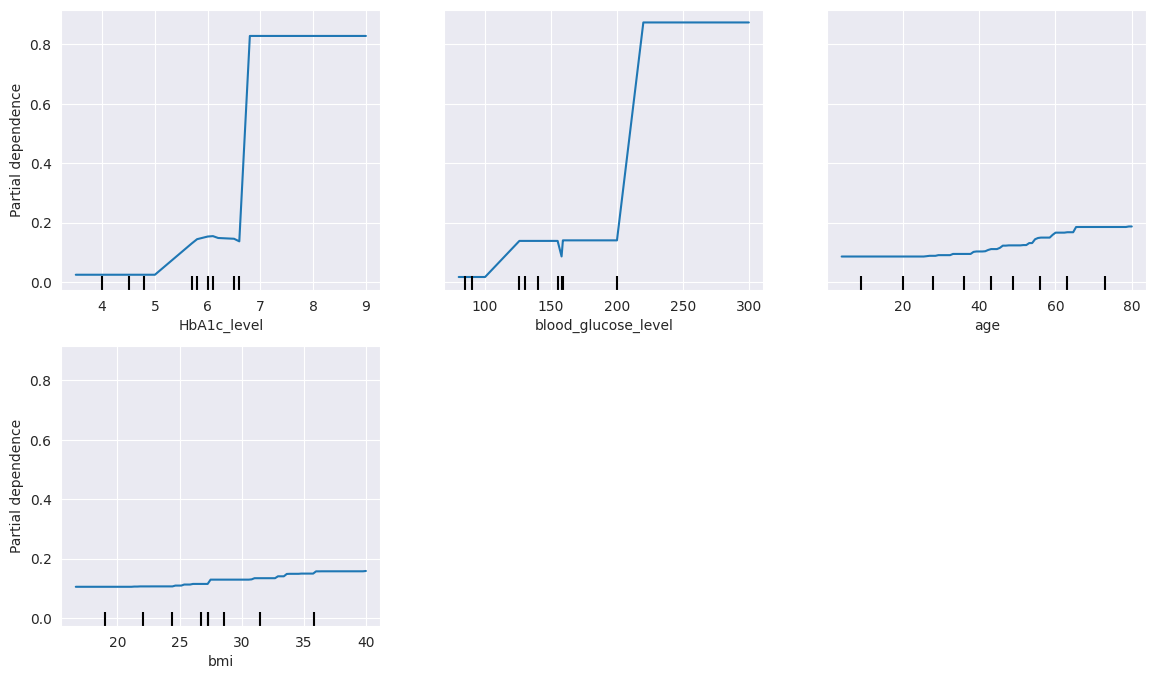

In [109]:
# Imports
fig, ax = plt.subplots(figsize=(14, 8))
disp2 = PartialDependenceDisplay.from_estimator(model, X_test_oh, ["HbA1c_level", "blood_glucose_level", "age", "bmi"], ax=ax)

plt.show()

In [ ]:
end_time = time.time() - start_time
minutes = end_time // 60
seconds = end_time - minutes * 60
print(f"Total notebook time: {minutes} minutes and {seconds:.2f} seconds")

Total notebook time: 59.0 minutes and 37.02 seconds


<b>Results</b>
<ul>
    <li>Test set performance was similar to cross validation performance which is expected.</li>
    <li>High values of <span style='color:#26a06c'>HbA1c_level</span> and  high values of <span style='color:#26a06c'>blood_glucose_level</span> predicted <span style='color:#3498db'>diabetes</span> and low values predicted not <span style='color:#3498db'>diabetes</span>.</li>
    <li><span style='color:#26a06c'>Age</span> had similar behaviour where high values predicted <span style='color:#3498db'>diabetes</span> and low values not <span style='color:#3498db'>diabetes</span>.</li>
    <li>High values of <span style='color:#26a06c'>BMI</span> increased the model's prediction towards <span style='color:#3498db'>diabetes</span>.</li>
    <li><span style='color:#26a06c'>Gender</span> and specificaly <b>male</b> inreased the model's prediction for <span style='color:#3498db'>diabetes</span>.</li>
    <li>The model ignored <span style='color:#26a06c'>heart_disease</span> and <span style='color:#26a06c'>hypertension</span>.</li>
</ul>

<h3>Summary</h3>

<p>Class imbalance affected the performance of the model a lot. The model performed very well on the majority class but not well on the minority class. For the minority class, higher values of oversampling were increasing the precision of the model (the percentage of the model being correct when predicted <span style='color:#3498db'>diabetes</span>) and decreasing the recall of the model (the percentage of the model to detect <span style='color:#3498db'>diabetes</span> cases). In reverse lower values of oversampling helped the model detect more <span style='color:#3498db'>diabetes</span> cases but at the cost of lowering the percentage of being correct when predicting <span style='color:#3498db'>diabetes</span>.</p>
<p>All data and model evidence show that <span style='color:#26a06c'>HbA1c_level</span>, <span style='color:#26a06c'>blood_glucose_level</span> and <span style='color:#26a06c'>age</span> are the most important factors for <span style='color:#3498db'>diabetes</span>. Which from a logical point of view makes perfect sense.</p>
<p>From model evaluation looks like the best way to improve model's performance would be to collect more <span style='color:#3498db'>diabetes</span> cases.</p>